In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

In [ ]:
from langchain.globals import set_verbose, set_debug

set_debug(False)
set_verbose(False)

In [ ]:
### LLM

repo_id = "meta-llama/Llama-3.1-8B-Instruct"     # answer llm
graph_llm_name = "gemini-2.0-flash-lite" 
embed_model_name = "all-MiniLM-L6-v2"

In [ ]:
# embedding model

from langchain_huggingface import HuggingFaceEmbeddings

# model_name="all-MiniLM-L6-v2"
# model_name="sentence-transformers/all-mpnet-base-v2"

embedding_model = HuggingFaceEmbeddings(model_name=embed_model_name)

In [ ]:
# [does answer generation, rest of the work] llm

from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint


llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    max_new_tokens=1024,
    do_sample=False,
    temperature=0,
    provider="auto",  # let Hugging Face choose the best provider for you
)

chat_model = ChatHuggingFace(llm=llm)

""" usage example

messages = "tell a joke"
ai_msg = chat_model.invoke(messages)

print(ai_msg.content)
"""

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

graph_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [ ]:
llm = graph_llm

In [ ]:
import os
from langchain_community.document_loaders import PyMuPDFLoader # <-- The key change is this import
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# --- PDF LOADING AND PROCESSING using PyMuPDF ---

# 1. Define the path to your folder of PDFs
pdf_folder_path = "./data_stored/"
print(f"Loading PDFs from: {pdf_folder_path}")

# 2. List all the PDF files in the folder
pdf_files = [f for f in os.listdir(pdf_folder_path) if f.endswith(".pdf")]

# 3. Load all the documents from the PDF files
all_documents = []
for pdf_file in pdf_files:
    file_path = os.path.join(pdf_folder_path, pdf_file)
    print(f"  - Loading document: {pdf_file}")
    # Use PyMuPDFLoader instead of PyPDFLoader
    loader = PyMuPDFLoader(file_path)
    # The loader splits the PDF into pages, each page is a Document
    pages = loader.load()

    start_index = 21  # Keep pages from page 22 onwards
    end_index = 171   # Keep pages before page 172

    cleaned_pages = [
        page for page in pages 
        if start_index <= page.metadata.get('page', 0) < end_index
    ]

    all_documents.extend(cleaned_pages)

print(f"Loaded a total of {len(all_documents)} pages from {len(pdf_files)} PDF files.")


In [ ]:

# 4. Split the loaded documents into smaller chunks (This part is unchanged)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200
)
doc_splits = text_splitter.split_documents(all_documents)

print(f"Split the documents into {len(doc_splits)} chunks.")

In [ ]:
from langchain_milvus import Milvus

# Add to Milvus
vectorstore = Milvus.from_documents(
    documents=doc_splits,
    collection_name="rag_milvus_att_1",
    embedding=embedding_model,
    connection_args={"uri": "./milvus_ingest_att_1.db"},
)
retriever = vectorstore.as_retriever()

In [ ]:
# GraphRAG Setup
from langchain_community.graphs import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

graph = Neo4jGraph()


graph_transformer = LLMGraphTransformer(
    llm=graph_llm,
)

graph_documents = graph_transformer.convert_to_graph_documents(doc_splits)

graph.add_graph_documents(graph_documents)

print(f"Graph documents: {len(graph_documents)}")
print(f"Nodes from 1st graph doc:{graph_documents[0].nodes}")
print(f"Relationships from 1st graph doc:{graph_documents[0].relationships}")

In [ ]:
# After converting to graph documents
for i, doc in enumerate(graph_documents):
    print(f"Document {i}:")
    print(f"  Nodes: {doc.nodes}")
    print(f"  Relationships: {doc.relationships}")
    print("---")

In [ ]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser


# prompt = PromptTemplate(
#     template="""You are a grader assessing relevance 
#     of a retrieved document to a user question. If the document contains keywords related to the user question, 
#     grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 
    
#     Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
#     Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     
#     Here is the retrieved document: 
#     {document}
    
#     Here is the user question: 
#     {question}
#     """,
#     input_variables=["question", "document"],
# )

prompt = PromptTemplate(
    template="""You are a grader assessing relevance
of a retrieved document to a user question. If the document contains keywords related to the user question,
grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals.

Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
Provide the binary score as a JSON with a single key 'score' and no premable or explaination.

**IMPORTANT:** Your response MUST be only the JSON object itself, without any surrounding text or markdown.

Here is the retrieved document:
{document}

Here is the user question:
{question}
""",
    input_variables=["question", "document"],
)


retrieval_grader = prompt | llm | JsonOutputParser()
question = "Do we have articles that talk about large language models?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(
    f'Is our answer relevant to the question asked: {retrieval_grader.invoke({"question": question, "document": doc_txt})}'
)

In [ ]:
### Generate

from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Context: {context} 
    Answer: 
    """,
    input_variables=["question", "document"],
)



def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

question = "Do we have articles that talk about large language models?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In [ ]:
### Graph Generate

from langchain.prompts import PromptTemplate
from langchain.chains import GraphCypherQAChain
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI


cypher_prompt = PromptTemplate(
    template="""You are an expert at generating Cypher queries for Neo4j.
    Use the following schema to generate a Cypher query that answers the given question.
    Make the query flexible by using case-insensitive matching and partial string matching where appropriate.
    Focus on searching paper titles as they contain the most relevant information.
    
    Schema:
    {schema}
    
    Question: {question}
    
    Cypher Query:""",
    input_variables=["schema", "question"],
)


qa_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following Cypher query results to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise. If topic information is not available, focus on the paper titles.
    
    Question: {question} 
    Cypher Query: {query}
    Query Results: {context} 
    
    Answer:""",
    input_variables=["question", "query", "context"],
)


graph_rag_chain = GraphCypherQAChain.from_llm(
    cypher_llm=graph_llm,
    qa_llm=llm,
    validate_cypher=True,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    return_direct=True,
    cypher_prompt=cypher_prompt,
    qa_prompt=qa_prompt,
    allow_dangerous_requests=True
)

question = "What paper talks about large language models?"
generation = graph_rag_chain.invoke({"query": question})
print(generation)

In [ ]:
### Composite Vector + Graph Generations

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.base import Chain


prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context from a vector store and a graph database to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Vector Context: {context} 
    Graph Context: {graph_context}
    Answer: 
    """,
    input_variables=["question", "context", "graph_context"],
)


# Example input data
question = "What paper talk about large language models?"

In [ ]:
# Get vector + graph answers
docs = retriever.invoke(question)

print(docs)

In [ ]:
vector_context = rag_chain.invoke({"context": docs, "question": question})

print(vector_context)

In [ ]:
graph_context = graph_rag_chain.invoke({"query": question})

print(graph_context)

In [ ]:
composite_chain = prompt | llm | StrOutputParser()
answer = composite_chain.invoke(
    {"question": question, "context": vector_context, "graph_context": graph_context}
)

print(answer)

In [ ]:
### Hallucination Grader


prompt = PromptTemplate(
    template="""You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation.
    
    Here are the facts:
    {documents} 

    Here is the answer: 
    {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
### Answer Grader


prompt = PromptTemplate(
    template="""You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     
    Here is the answer:
    {generation} 

    Here is the question: {question}
    """,
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

In [ ]:
### Router

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser


prompt = PromptTemplate(
    template="""You are an expert at routing a user question to the most appropriate data source. 
    You have three options:
    1. 'vectorstore': Use for questions about LLM agents, prompt engineering, and adversarial attacks.
    2. 'graphrag': Use for questions that involve relationships between entities, such as authors, papers, and topics, or when the question requires understanding connections between concepts.
    3. 'web_search': Use for all other questions or when current information is needed.

    You do not need to be stringent with the keywords in the question related to these topics. 
    Choose the most appropriate option based on the nature of the question.

    Return a JSON with a single key 'datasource' and no preamble or explanation. 
    The value should be one of: 'vectorstore', 'graphrag', or 'web_search'.
    
    Question to route: 
    {question}""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

In [ ]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

We'll implement these as a control flow in LangGraph.

In [ ]:
from typing_extensions import TypedDict
from typing import List

### State
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
        graph_context: results from graph search
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    graph_context: str


from langchain.schema import Document

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents and graph context

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state.get("documents", [])
    graph_context = state.get("graph_context", "")

    # Composite RAG generation
    generation = composite_chain.invoke(
        {"question": question, "context": documents, "graph_context": graph_context}
    )
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "graph_context": graph_context,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])  # Use get() with a default empty list

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Conditional edge
def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])

    if source["datasource"] == "graphrag":
        print("---TRYING GRAPH SEARCH---")
        graph_result = graph_search({"question": question})
        if graph_result["graph_context"] != "No results found in the graph database.":
            return "graphrag"
        else:
            print("---NO RESULTS IN GRAPH, FALLING BACK TO VECTORSTORE---")
            return "retrieve"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO VECTORSTORE RAG---")
        return "retrieve"
    elif source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def graph_search(state):
    """
    Perform GraphRAG search using Neo4j

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated state with graph search results
    """
    print("---GRAPH SEARCH---")
    question = state["question"]

    # Use the graph_rag_chain to perform the search
    result = graph_rag_chain.invoke({"query": question})

    # Extract the relevant information from the result
    # Adjust this based on what graph_rag_chain returns
    graph_context = result.get("result", "")

    # You might want to combine this with existing documents or keep it separate
    return {"graph_context": graph_context, "question": question}


### Conditional edge
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = grade = score.get("score", "").lower()

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("graphrag", graph_search)

### Graph Build

In [ ]:
# Set conditional entry point
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "retrieve": "retrieve",
        "graphrag": "graphrag",
    },
)

# Add edges
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("graphrag", "generate")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [ ]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint

inputs = {"question": "What are large language models?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

In [ ]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint

inputs = {"question": "Did Emmanuel Macron visit Germany recently?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

In [ ]:
# Test
from pprint import pprint

inputs = {"question": "Which paper talk about large language models?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

# Give us a star on Github ⭐️

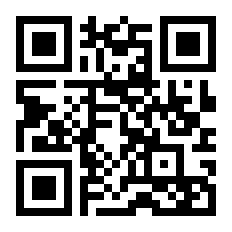

# Add me on LinkedIn
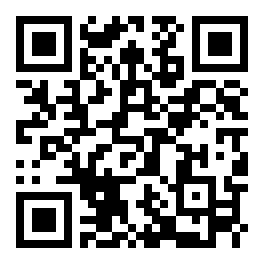